# Examine some of the results for ReFrame compounds

Here we will look at ReFrame compounds and the diseases they're predicted to treat.  For this, we will only use the subset of diseases with a known treatment (whether palative or disease modifying) within the network.

In [1]:
import pickle
import numpy as np
import pandas as pd
from pathlib import Path

%matplotlib inline
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
load_dir = Path('../2_pipeline').resolve()
model_name = '13_Final_Model_Training'

nw_dir = load_dir.joinpath('10_Semmantic_Compression', 'out')
hyp_dir = load_dir.joinpath('11c_Model_Prep_Hyperparam_tuning', 'out')
model_dir = load_dir.joinpath(model_name, 'out')

### Load and process the network

In [3]:
nodes = pd.read_csv(nw_dir.joinpath('nodes_biolink.csv'), dtype=str)
edges = pd.read_csv(nw_dir.joinpath('edges_biolink.csv'), dtype=str)

In [4]:
best_param = pickle.load(open(hyp_dir.joinpath('best_param.pkl'), 'rb'))

In [5]:
from hetnet_ml.extractor import MatrixFormattedGraph
mg = MatrixFormattedGraph(nodes, edges, 'ChemicalSubstance', 'Disease', max_length=4, w=best_param['w'], n_jobs=30)

Processing node and edge data...
Initializing metagraph...
Generating adjacency matrices...


100%|██████████| 96/96 [02:02<00:00,  1.27s/it]



Determining degrees for each node and metaedge


100%|██████████| 96/96 [00:30<00:00,  3.16it/s]



Weighting matrices by degree with dampening factor 0.5267957740707717...


100%|██████████| 96/96 [00:01<00:00, 51.03it/s]


### Get relevent elements of model

In [6]:
model = pickle.load(open(model_dir.joinpath('model.pkl'), 'rb'))

/opt/mmayers/software/anaconda3/envs/ml/lib/python3.6/site-packages/data_tools/df_processing.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [7]:
metapaths = pd.read_csv(hyp_dir.joinpath('kept_features.txt'), header=None)[0].tolist()

In [8]:
from data_tools.graphs import dataframes_to_metagraph, metapaths_to_json
metagraph = dataframes_to_metagraph(nodes, edges)

all_metapaths = metagraph.extract_metapaths('ChemicalSubstance', 'Disease', 4)
mp_info = {mp.abbrev: mp for mp in all_metapaths if mp.abbrev in metapaths}

In [9]:
res = pd.read_csv(model_dir.joinpath('results.csv'))
coef = pd.read_csv(model_dir.joinpath('coef.csv'))

In [10]:
res.head(2)

,chemicalsubstance_id,disease_id,status,proba
0,CHEBI:100,DOID:0002116,0,0.006045
1,CHEBI:100,DOID:0014667,0,0.005136


In [11]:
len(res)

85126262

In [12]:
id_to_name = nodes.set_index('id')['name'].to_dict()
res['chem_name'] = res['chemicalsubstance_id'].map(id_to_name)
res['dis_name'] = res['disease_id'].map(id_to_name)

In [13]:
pos_coef = coef.query('coef > 0')['feature'].tolist()

In [14]:
msat = model[0]
max_abs = model[1]

In [15]:
ini_means = {f: m for f, m in zip(metapaths, msat.initial_mean_)}
ma_scale = {f: m for f, m in zip(metapaths, max_abs.scale_)}
feat_coef = coef.set_index('feature')['coef'].to_dict()
feat_zcoef = coef.set_index('feature')['zcoef'].to_dict()

### Definie routines for extracting and weighting paths

In [16]:
def get_model_metric(path_df):
    totals = path_df.groupby('metapath')['metric'].sum().to_dict()
    percent_of_total = path_df['metric'] / path_df['metapath'].map(totals)
    
    trans_metric = np.arcsinh(path_df['metapath'].map(totals) / path_df['metapath'].map(ini_means))
    scal_metric = trans_metric / path_df['metapath'].map(ma_scale)
    
    model_metric = scal_metric * path_df['metapath'].map(feat_coef) * percent_of_total
    return model_metric

In [17]:
def get_std_model_metric(path_df):
    
    totals = path_df.groupby('metapath')['metric'].sum().to_dict()
    percent_of_total = path_df['metric'] / path_df['metapath'].map(totals)
    
    trans_metric = np.arcsinh(path_df['metric'] / path_df['metapath'].map(ini_means))
    scal_metric = trans_metric / path_df['metapath'].map(ma_scale)
    
    model_metric = scal_metric * path_df['metapath'].map(feat_zcoef) * percent_of_total
    return model_metric

In [18]:
def get_path_info(compound, disease, n_jobs=30):
    path_df = pd.DataFrame(mg.extract_paths(compound, disease, pos_coef, n_jobs=n_jobs))
    path_df['model_metric'] = get_model_metric(path_df)
    path_df['std_metric'] = get_std_model_metric(path_df)
    
    return path_df

In [19]:
ref_c = nodes[~nodes['source'].isnull()]['id'].unique()
len(ref_c)

5988

In [20]:
all_dis = res['disease_id'].unique()
len(all_dis)

6838

### Get probabilities from model for ReFrame - Disease pairs

In [21]:
(ref_pairs, out_mp), dwpc = mg.extract_dwpc(metapaths=metapaths, start_nodes=ref_c, 
                                        end_nodes=list(all_dis), n_jobs=30, return_sparse=True, sparse_df=False)

Preparing function arguments...
Calculating DWPCs...


100%|██████████| 196/196 [03:23<00:00,  1.04s/it]



Reshaping Result Matrices...


100%|██████████| 196/196 [00:39<00:00,  4.92it/s]


Stacking columns...


In [22]:
ref_pairs['proba'] = model.predict_proba(dwpc)[:, 1]

/opt/mmayers/software/anaconda3/envs/ml/lib/python3.6/site-packages/scipy/sparse/data.py:132: RuntimeWarning: overflow encountered in arcsinh
  result = op(self._deduped_data())
/opt/mmayers/software/anaconda3/envs/ml/lib/python3.6/site-packages/scipy/sparse/data.py:132: RuntimeWarning: invalid value encountered in arcsinh
  result = op(self._deduped_data())


In [23]:
ref_pairs['chem_name'] = ref_pairs['chemicalsubstance_id'].map(id_to_name)
ref_pairs['dis_name'] = ref_pairs['disease_id'].map(id_to_name)

In [24]:
pos_tups = set(edges.query('type == "treats_CtD"')[['start_id', 'end_id']].apply(tuple, axis=1))

In [25]:
status = []
for row in ref_pairs.itertuples():
    tup = (row.chemicalsubstance_id, row.disease_id)
    status.append(int(bool(pos_tups & {tup})))

In [26]:
ref_pairs['status'] = status
ref_pairs.sample(10)

,chemicalsubstance_id,disease_id,proba,chem_name,dis_name,status
22591607,CHEBI:8633,MESH:D015435,0.007335,puerarin,"Panniculitis, Lupus Erythematosus",0
30842481,IKEY:IPGLIOFIFLXLKR-UHFFFAOYSA-N,DOID:3492,0.004867,Adaprolol,mixed connective tissue disease,0
19886269,CHEBI:74846,DOID:10803,0.005806,azaserine,Haemophilus influenzae meningitis,0
3139956,CHEBI:135466,DOID:10602,0.007818,nafamostat,steatorrhea busuk,0
15596674,CHEBI:51241,MONDO:0008999,0.005477,carphenazine maleate,Cohen syndrome,0
8433025,CHEBI:31253,DOID:12176,0.003573,Barnidipine hydrochloride,goiter,0
7733970,CHEBI:29014,DOID:0050490,0.005659,cordycepin,parenchymatous neurosyphilis,0
38932733,IKEY:WVOJPPFIOABHAB-UHFFFAOYSA-N,DOID:5705,0.005659,Entospletinib dimesylate,spindle cell liposarcoma,0
21810656,CHEBI:82707,DOID:679,0.015461,ergothioneine thione form,basal ganglia disease,0
29963333,IKEY:HITYEEHTEOQBAC-OSIGYOHNSA-N,MONDO:0010122,0.004971,Ecraprost,Upshaw Schulman Syndrome,0


### Save out results

In [27]:
this_name = '14c_Model_results_analysis_Reframe_pos'
out_dir = load_dir.joinpath(this_name, 'out')

out_dir.mkdir(exist_ok=True, parents=True)

ref_pairs.to_csv(out_dir.joinpath('reframe_probas.csv'), index=False)

In [28]:
ref_pairs = ref_pairs.sort_values('proba', ascending=False).reset_index(drop=True)
ref_pairs.head(50)

,chemicalsubstance_id,disease_id,proba,chem_name,dis_name,status
0,CHEBI:87690,DOID:0060224,0.998078,"N-(2,6-dimethylphenyl)-2-\{4-[2-hydroxy-3-(2-m...",atrial fibrillation,0
1,CHEBI:27300,DOID:10609,0.997832,vitamin D,rickets,1
2,CHEBI:50749,DOID:0050445,0.997447,calcipotriol,X-linked hypophosphatemic rickets,0
3,CHEBI:36276,DOID:13580,0.997419,sodium taurocholate,cholestasis,0
4,CHEBI:134718,DOID:0060224,0.997308,safinamide,atrial fibrillation,0
5,CHEBI:28834,DOID:13580,0.997060,deoxycholic acid,cholestasis,0
6,CHEBI:50749,DOID:10609,0.997025,calcipotriol,rickets,0
7,CHEBI:16359,DOID:13580,0.995689,cholic acid,cholestasis,0
8,CHEBI:16359,DOID:1852,0.994707,cholic acid,intrahepatic cholestasis,0
9,CHEBI:28834,DOID:1852,0.994408,deoxycholic acid,intrahepatic cholestasis,0


### Plot a couple of path examples

In [29]:
edge_info = pd.read_csv('../0_data/manual/edge_semtypes.csv')
inv_map = edge_info.set_index('fwd_edge')['rev_edge'].to_dict()

In [30]:

# Choose custom node colors
node_color_map = {'AnatomicalEntity': '#5252b9',
                'BiologicalProcessOrActivity': '#fc99d5',
                'MacromolecularMachine': '#d032a3',
                'Disease': '#50e316',
                'Pathway': '#b7d165',
                'PhenotypicFeature': '#165f28',
                'GeneFamily': '#6404b7',
                'PhysiologicalProcess': '#ec102f',
                'OrganismTaxon': '#e9bf98',
                'ChemicalSubstance': '#21f0b6'}

node_id_to_color = nodes.set_index('id')['label'].map(node_color_map).to_dict()
id_to_label = nodes.set_index('id')['label'].to_dict()


import graph_plots as gp

def draw_top_paths(path_df, head_num=10, metric='model_metric', poi_idx=None, proba=None):


    if poi_idx is not None:
        path_of_interest = path_df.loc[poi_idx, 'node_ids']
    else:
        path_of_interest = []
        
    top_n_paths = path_df.sort_values(metric, ascending=False).head(head_num)

    # Get the list of paths
    list_of_paths = top_n_paths['node_ids'].tolist()
    path_weights = top_n_paths[metric].tolist()

    # Get the edge names
    list_of_edges = []
    for mp in top_n_paths['metapath']:
        list_of_edges.append(gp.parse_metapath_to_edge_names(mp, mp_info, inv_map))

    edge_color_map = gp.highlight_path_of_interest(list_of_paths, path_of_interest)

    G = gp.build_explanitory_graph(list_of_paths, list_of_edges, path_weights=path_weights, 
                                node_id_to_label=id_to_label, node_id_to_color=node_id_to_color, 
                                edge_id_to_color=edge_color_map)

    gp.draw_explanitory_graph(G, node_id_to_name=id_to_name, proba=proba, n_paths=len(list_of_paths));


In [31]:
# networkx throws LOTS of matplotlib warnings when plotting, so we're silencing
import warnings
warnings.simplefilter('ignore')

In [32]:
ref_pairs.query('status == 0').head(100).tail(50)

,chemicalsubstance_id,disease_id,proba,chem_name,dis_name,status
63,CHEBI:18358,DOID:13580,0.976898,methoxsalen,cholestasis,0
64,CHEBI:44915,DOID:1826,0.976406,propofol,epilepsy,0
65,CHEBI:34732,DOID:0060224,0.976266,E-4031,atrial fibrillation,0
66,CHEBI:73272,MESH:D013217,0.975779,canagliflozin hydrate,Starvation,0
67,CHEBI:231177,DOID:1247,0.975592,Ethyl biscoumacetate,blood coagulation disease,0
68,CHEBI:34732,DOID:2843,0.975505,E-4031,long QT syndrome,0
70,CHEBI:33216,MESH:D008106,0.974429,bisphenol A,"Liver Cirrhosis, Experimental",0
71,CHEBI:33216,MESH:D008175,0.974124,bisphenol A,lung neoplasm,0
72,CHEBI:92833,DOID:10763,0.974083,"2-[4-(1,3-benzodioxol-5-ylmethyl)-1-piperaziny...",hypertension,0
73,CHEBI:31186,DOID:0050445,0.973994,alfacalcidol,X-linked hypophosphatemic rickets,0


In [33]:
def plot_idx(test_idx, njob=30):

    cid = ref_pairs.loc[test_idx, 'chemicalsubstance_id']
    did = ref_pairs.loc[test_idx, 'disease_id']
    prob = ref_pairs.loc[test_idx, 'proba']

    print('Extracting data for: {} -TREATS- {}'.format(id_to_name[cid], id_to_name[did]))
    path_df = get_path_info(cid, did, njob)

    draw_top_paths(path_df, 10, proba=prob)

In [34]:
ref_pairs.query('status == 0 and dis_name == "atrial fibrillation"').head(10)

,chemicalsubstance_id,disease_id,proba,chem_name,dis_name,status
0,CHEBI:87690,DOID:0060224,0.998078,"N-(2,6-dimethylphenyl)-2-\{4-[2-hydroxy-3-(2-m...",atrial fibrillation,0
4,CHEBI:134718,DOID:0060224,0.997308,safinamide,atrial fibrillation,0
16,CHEBI:9468,DOID:0060224,0.991635,tetracaine,atrial fibrillation,0
22,CHEBI:31229,DOID:0060224,0.989524,Aprindine hydrochloride,atrial fibrillation,0
65,CHEBI:34732,DOID:0060224,0.976266,E-4031,atrial fibrillation,0
130,CHEBI:77431,DOID:0060224,0.967500,"1-butyl-N-(2,6-dimethylphenyl)piperidine-2-car...",atrial fibrillation,0
131,CHEBI:6456,DOID:0060224,0.967430,lidocaine,atrial fibrillation,0
139,CHEBI:134966,DOID:0060224,0.966060,rufinamide,atrial fibrillation,0
142,CHEBI:28748,DOID:0060224,0.964839,doxorubicin,atrial fibrillation,0
152,CHEBI:135568,DOID:0060224,0.963438,lorcainide,atrial fibrillation,0


Extracting data for: lidocaine -TREATS- atrial fibrillation


100%|██████████| 113/113 [00:58<00:00,  1.94it/s]


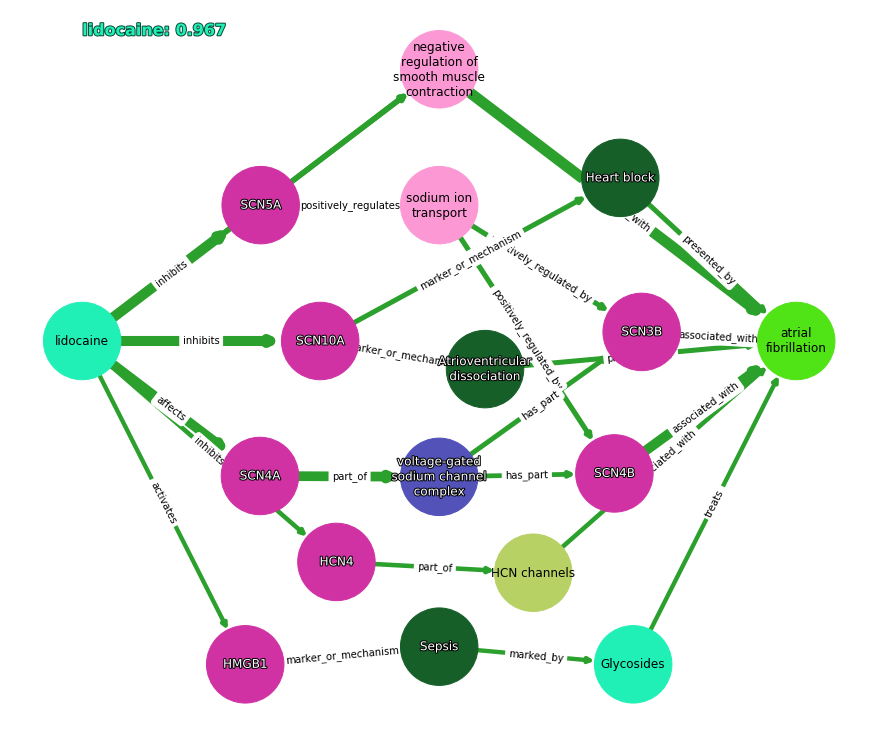

In [35]:
test_idx = 131

cid = ref_pairs.loc[test_idx, 'chemicalsubstance_id']
did = ref_pairs.loc[test_idx, 'disease_id']
prob = ref_pairs.loc[test_idx, 'proba']

print('Extracting data for: {} -TREATS- {}'.format(id_to_name[cid], id_to_name[did]))
path_df = get_path_info(cid, did, 30)

draw_top_paths(path_df, 10, proba=prob)

In [36]:
ref_pairs.query('status == 0 and dis_name == "long QT syndrome"').head(10)

,chemicalsubstance_id,disease_id,proba,chem_name,dis_name,status
18,CHEBI:87690,DOID:2843,0.991429,"N-(2,6-dimethylphenyl)-2-\{4-[2-hydroxy-3-(2-m...",long QT syndrome,0
68,CHEBI:34732,DOID:2843,0.975505,E-4031,long QT syndrome,0
171,CHEBI:77733,DOID:2843,0.960985,"2-(3,4-dimethoxyphenyl)-5-\{[2-(3,4-dimethoxyp...",long QT syndrome,0
207,CHEBI:77431,DOID:2843,0.958757,"1-butyl-N-(2,6-dimethylphenyl)piperidine-2-car...",long QT syndrome,0
212,CHEBI:9468,DOID:2843,0.957759,tetracaine,long QT syndrome,0
302,CHEBI:28462,DOID:2843,0.944563,ajmaline,long QT syndrome,0
361,CHEBI:31229,DOID:2843,0.938997,Aprindine hydrochloride,long QT syndrome,0
383,CHEBI:93095,DOID:2843,0.936441,"2-[4-[4,4-bis(4-fluorophenyl)butyl]-1-piperazi...",long QT syndrome,0
447,CHEBI:134718,DOID:2843,0.929540,safinamide,long QT syndrome,0
477,CHEBI:5139,DOID:2843,0.927257,Fluvoxamine maleate,long QT syndrome,0


Extracting data for: E-4031 -TREATS- long QT syndrome


100%|██████████| 113/113 [00:02<00:00, 40.19it/s]


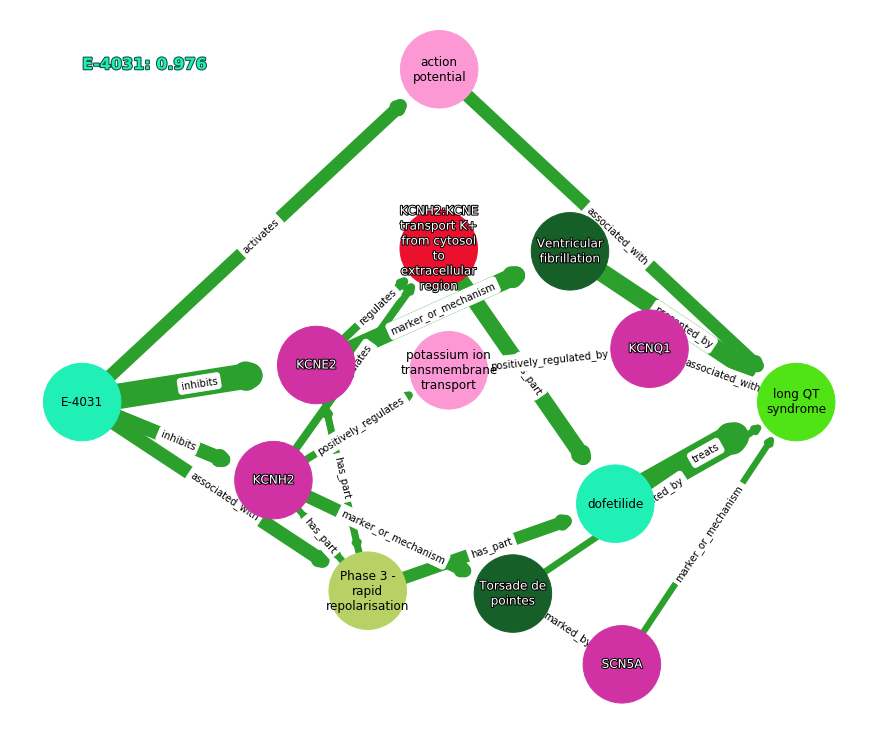

In [37]:
test_idx = 68

cid = ref_pairs.loc[test_idx, 'chemicalsubstance_id']
did = ref_pairs.loc[test_idx, 'disease_id']
prob = ref_pairs.loc[test_idx, 'proba']

print('Extracting data for: {} -TREATS- {}'.format(id_to_name[cid], id_to_name[did]))
path_df = get_path_info(cid, did, 30)

draw_top_paths(path_df, 10, proba=prob)

In [38]:
ref_pairs.query('status == 0 and dis_name == "psychosomatic disease"').reset_index().query('chem_name == "Naftopidil"')

,index,chemicalsubstance_id,disease_id,proba,chem_name,dis_name,status
32,45843,CHEBI:31891,MESH:D011602,0.322074,Naftopidil,psychosomatic disease,0


Extracting data for: Naftopidil -TREATS- psychosomatic disease


100%|██████████| 113/113 [00:01<00:00, 76.23it/s]


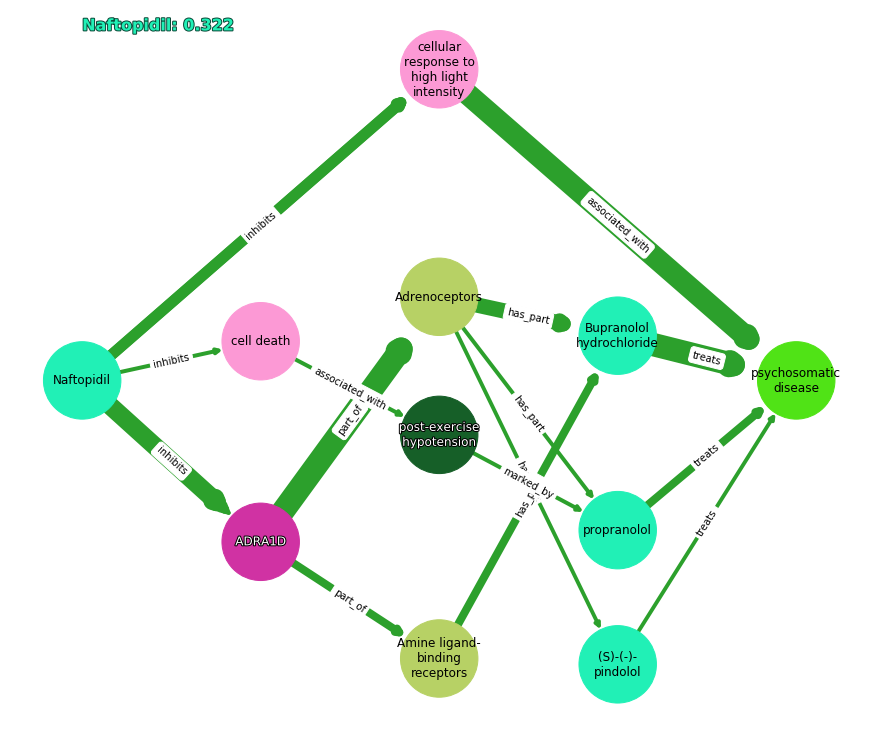

In [39]:
plot_idx(45843)